In [125]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [219]:
d1 = pd.read_csv('../dados/oferta_2025_1_depto-estatística---brasília_graduação.csv')
d1['nivel'] = 'graduação'
d2 = pd.read_csv('../dados/oferta_2025_1_programa-de-pós-graduação-em-estatística---brasília_stricto senso.csv')
d2['nivel'] = 'mestrado'
dados = pd.concat([d1, d2], ignore_index=True)
dados['carga_horaria_semanal'] = (dados['carga_horaria']/15).astype(int)
dados.loc[dados['codigo_disciplina'].str.startswith('PPGEST'), 'horario'] = dados.loc[dados['codigo_disciplina'].str.startswith('PPGEST'), 'horario'].str.split('(').str[0]
dados = dados[dados['disciplina'] != 'ESTÁGIO DE DOCÊNCIA NO ENSINO DE GRADUAÇÃO EM ESTATÍSTICA']

In [220]:
#Definindo função que localiza o primeiro a informação do turno
def loc_primeira_letra(codificacao):
    match = re.search(r'[MTN]', codificacao)
    if match:
        return match.group()
    return None

#Definindo função que retorna o dia da semana e o horario da aula
def converter_horario(codificacao):
    codificacao = codificacao.strip()
    dias_semana = {'2': 'Segunda', '3': 'Terça', '4': 'Quarta', '5': 'Quinta', '6': 'Sexta', '7': 'Sábado'}
    turnos = {'M': {'1': '08:00', '2': '09:00', '3': '10:00', '4': '11:00', '5': '12:00'},
              'T': {'1': '13:00', '2': '14:00', '3': '15:00', '4': '16:00', '5': '17:00', '6': '18:00'},
              'N': {'1': '19:00', '2': '20:00', '3': '20:50', '4':'21:50'}}
    
    turno = loc_primeira_letra(codificacao.strip())
    dia = [dias_semana.get(x) for x in codificacao.split(turno)[0]]
    horario = [turnos.get(turno).get(x) for x in codificacao.split(turno)[1]]
    return dia, horario

def agrupar_horarios(horario):
    """
    Transforma os horários de início das aulas nos blocos de horário utilizados pela UnB
    """
    blocos = {
        '08:00': '08:00-09:50', '09:00': '08:00-09:50',
        '10:00': '10:00-11:50', '11:00': '10:00-11:50',
        '12:00': '12:00-13:50', '13:00': '12:00-13:50',
        '14:00': '14:00-15:50', '15:00': '14:00-15:50',
        '16:00': '16:00-17:50', '17:00': '16:00-17:50',
        '18:00': '18:00-19:50',
        '19:00': '19:00-20:40', '20:00': '19:00-20:40',
        '20:50': '20:50-22:30', '21:50': '20:50-22:30',
    }
    return blocos.get(horario, horario)


In [221]:
#Aplica funções para criar colunas com lista de dias e horários
dados_horarios = dados['horario'].apply(converter_horario).apply(pd.Series).rename(columns={0: 'dia', 1: 'hora'})
#Adiciona colunas ao dataframe original
dados = pd.concat([dados, dados_horarios], axis=1)
#Adiciona uma nova observação para dia que a materia tem aula
dados_horarios_expandido = dados[['codigo_disciplina', 'codigo_turma', 'dia', 'hora']].explode('dia').explode('hora')
#Descarta as observações que representam a mesma aula do mesmo dia
dados_horarios_expandido = dados_horarios_expandido.drop_duplicates(subset=['codigo_disciplina', 'codigo_turma', 'dia']).reset_index(drop=True)

#Transforma a hora de inicio nos formatos de horário da unb
dados_horarios_expandido['hora_agrupada'] = dados_horarios_expandido['hora'].apply(agrupar_horarios)

#Transforma as variáveis em dados categóricos
dados_horarios_expandido['dia'] = pd.Categorical(dados_horarios_expandido['dia'], categories=['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado'], ordered=True)

heatmap_data_agrupado = pd.crosstab(dados_horarios_expandido['dia'], dados_horarios_expandido['hora_agrupada']).transpose()


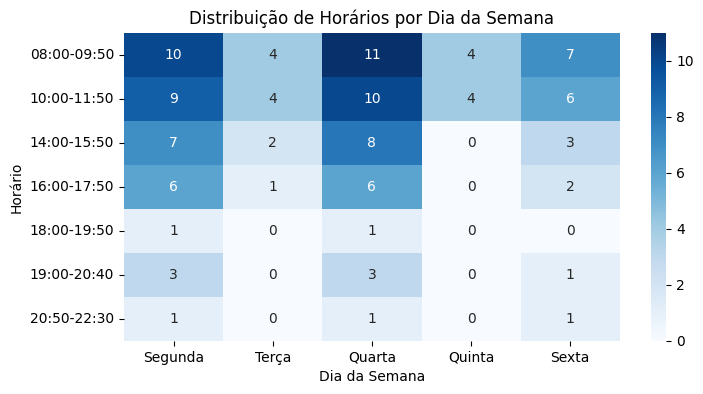

In [231]:
plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_data_agrupado, annot=True, cmap='Blues')
plt.title('Distribuição de Horários por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Horário')
plt.yticks(rotation=0) 
plt.savefig('../imagens/heatmap_distribuicao_horarios.pdf', format='pdf')
plt.show()

In [235]:
disciplinas = dados.groupby(['codigo_disciplina', 'disciplina']).agg(
    n_turmas = ('codigo_turma', 'nunique'),
    n_vagas = ('vagas_ocupadas', 'sum'),
    media_vagas = ('vagas_ocupadas', 'mean'),
    n_horarios = ('horario', 'nunique'),
    n_professores = ('docente', 'nunique')
    ).reset_index()

In [241]:
pd.DataFrame(disciplinas['n_turmas'].value_counts()).reset_index().to_clipboard(index=False, header=['n_turmas', 'n_disciplinas'])

In [251]:
professores = dados.groupby(['docente']).agg(
    n_materias = ('codigo_disciplina', 'nunique'),
    grad_count = ('nivel', lambda x: (x == 'graduação').sum()),
    mestrado_count = ('nivel', lambda x: (x == 'mestrado').sum()),
    n_turmas = ('codigo_turma', 'count'),
    n_horarios = ('horario', 'nunique'),
    carga_horaria_semestre = ('carga_horaria', 'sum'),
    carga_horaria_semanal = ('carga_horaria_semanal', 'sum')
    
    ).reset_index()

In [247]:
pd.DataFrame(professores['carga_horaria_semanal'].value_counts()).reset_index().sort_values('carga_horaria_semanal')#.to_clipboard(index=False, header=['carga_horaria_semanal', 'n_turmas'])

,carga_horaria_semanal,count
4,2,1
3,4,2
0,8,15
1,10,6
2,12,4


In [254]:
pd.DataFrame(professores['n_materias'].value_counts()).reset_index().sort_values('n_materias').to_clipboard(index=False, header=['n_materias', 'n_professores'])